# Route Simulation

In [ ]:
import csv
from typing import List, Dict, Set, Tuple
import glob
import math
import random

## Route Network

In [ ]:
class Stop(object):
    def __init__(self, name, edges=None, stop_time=0, is_depot=False, charging_capacity=None):
        '''
        Constructor for Stop class.

        Parameters:
        name:str Name of stop
        edges:Dict[str, Edge] Python Dictionary mapping the route directions to edges
        stop_time:float Number of seconds that the bus waits at this stop
        is_depot:bool True if this stop is a bus depot
        '''
        self._name = name
        self.edges = edges
        self.chargers = list()
        self.stop_time = stop_time # s
        self.is_depot = is_depot
        self.charging_capacity=charging_capacity

    def add_chargers(self, charger_rating=450, num_chargers=1):
        '''
        Method that adds a charger to the stop.

        Parameters:
        charger_rating:float POwer output of the charger
        num_chargers:int The number of chargers with this rating to add to the stop.
        '''
        # charger_rating in KWh
        for i in range(num_chargers):
            self.chargers.append(Charger(f"{self.name} Charger {len(self.chargers) + 1}", charger_rating))

    def shortest_charger_queue(self):
        '''
        Method that returns the index of the shortest charger in the stop, if any.

        Returns:
        int Index of the charger with the shortest queue in this stop or
        -1 if there are no chargers in this stop.
        '''
        shortest = -1
        for i in range(len(self.chargers)):
            if shortest == -1 or len(self.chargers[i].queue) < len(self.chargers[shortest].queue):
                shortest = i
        return shortest

    def has_charger(self):
        '''
        Method that returns if this stop has a charger.

        Returns:
        bool True if the stop has a charger
        '''
        return len(self.chargers) > 0

    def buses_in_queue(self, i):
        '''
        Method that returns the number of buses currently in the charger queue.
        
        Parameters:
        i:int Index of the charger in the stop

        Returns:
        int Number of buses in the ith charger
        '''
        return self.chargers[i].queue_length()

    def add_bus_to_charger_queue(self, i, bus):
        '''
        Method that adds bus to the ith charger's queue.

        Parameters:
        i:int Index of the charger in the stop
        bus:Bus Bus object
        '''
        self.chargers[i].add_bus(bus)
        bus.is_charging = True

    def charge_all_buses(self, timestep): # timestamp in seconds
        '''
        Method that charges all the buses in the charger queue at this stop.

        Parameters:
        timestep:float Number of seconds to charge the buses for

        '''
        num_chargers_in_use=0
        for charger in self.chargers:
            if charger.queue_length() >= 1:
                num_chargers_in_use=num_chargers_in_use+1
        for charger in self.chargers:
            if charger.queue_length() >= 1:
                bus = charger.queue[0] # bus at the front of queue
                charge_rate=self.charging_capacity/num_chargers_in_use
                #charge_rate = charger.charge_rate(bus.SOC(), bus.charge_rate, len(self.chargers))
                charger.output_rate = charge_rate
                ### ADD LINE TO MAKE CHARGE RATE EQUAL TO MAX CHARGE LIMIT/NUM BUSES CHARGING
                new_charge = bus.battery_charge + charge_rate * (timestep/3600)  #DIVIDED TIME TO CONVERT TO HRS
                bus.battery_charge = min(new_charge, bus.battery_capacity) # KWh
                if bus.SOC()>=0.9:
                #if bus.can_reach_next_stop(): # bus charged enough
                    if self.is_depot: # bus at depot
                        bus.route_direction = bus.prev_route_direction # return to original route
                        bus.distance_to_next_stop = self.edges[bus.route_direction].length
                    charger.queue.pop(0) # Remove bus from queue
                    bus.is_charging = False
            else:
                charger.output_rate = 0

    def connects_to_depot(self, route):
        '''
        Method that checks whether this stop connects to a depot.

        Returns:
        bool True if this stop connects to a depot
        '''
        return ("to depot of " + route) in self.edges

    def __eq__(self, other):
        if not isinstance(other, Stop):
            return False
        return self.name == other.name and self.has_charger == other.has_charger

    def __hash__(self):
        return hash((self.name, self.has_charger))

    @property
    def name(self):
        return self._name

    def __str__(self):
        return f"{self.name}"

    def __repr__(self):
        return f"{self.name}"

class Edge(object):
    def __init__(self, length, next_stop):
        '''
        Constructor for the Edge class.

        Parameters:
        length:float Distance between the stops in kilometers that the edges connect
        next_stop:Stop The next stop
        '''
        self._length = length # Km
        self._next_stop = next_stop
    
    @property
    def length(self):
        return self._length
    
    @property
    def next_stop(self):
        return self._next_stop
    
    def __str__(self):
        return f"{self.length} Km to {self.next_stop}"

class StopNetwork(object):
    def __init__(self):
        '''
        Constructor for the StopNetwork class.
        '''
        self.stops = dict() # Dictionary of Stop name -> Stop object
        self.routes = dict() # Dictionary of Route name -> Route object
        
    def add_edge(self, origin_name, dest_name, route_name, route_direction, length, stop_time=30):
        '''
        Method that adds an edge to this network.

        Parameters:
        origin_name:str Name of the stop where this edge starts from
        dest_name:str Name of the stop where this edge ends at
        route_name:str Name of the route that this edge belongs to
        route_direction:str Name of the direction that this edge belongs to
        length:float Distance between the twp stops in kilometers
        stop_time:float Number of seconds that a bus waits at the origin and destination stops
        '''
        # Populate stops dictionary
        if origin_name not in self.stops:
            self.stops[origin_name] = Stop(origin_name, {}, stop_time)
        if dest_name not in self.stops:
            self.stops[dest_name] = Stop(dest_name, {}, stop_time)
        self.stops[origin_name].edges[route_direction] = Edge(length, self.stops[dest_name])
        
        # Populate routes dictionary
        if route_name not in self.routes:
            self.routes[route_name] = Route(route_name)
        self.routes[route_name].add_stop(self.stops[origin_name], route_direction)
        
    def add_bus(self, bus_id, speed, cur_stop_name, route_name, route_direction, battery_capacity, battery_charge, energy_use_per_km):
        '''
        Method that adds a bus to the network.

        Parameters:
        bus_id:int Id of the bus
        speed:float Speed of the bus in km/hr
        cur_stop_name:str The stop where the bus is starting from
        route_name:str The name of the route that the bus belongs to
        route_direction:str The direction in the route that the bus is going to start from
        battery_capacity:float The amount of kilowatt-hours the battery can hold
        battery_charge:float The amount of energy (in kilowatt-hours) that the battery starts with
        energy_use_per_km:float The amount of kilowatt-hours the bus consumes per kilometer traveled (constant)
        '''
        new_bus = Bus(bus_id, speed, self.stops[cur_stop_name], self.routes[route_name], route_direction, battery_capacity, battery_charge, energy_use_per_km)
        self.routes[route_name].add_bus(new_bus)
        print(new_bus.battery_capacity)
        
    def move_all_buses(self, timestep): # timestep in seconds
        '''
        Method that moves all the buses in the network by the specified timestep.

        Parameters:
        timestep:float Number of seconds to move the buses by
        '''
        for route in self.routes.values():
            for bus in route.buses:
                bus.move(timestep)
                
    def charge_all_buses(self, timestamp): # timestamp in seconds
        '''
        Method that charges all the buses in the network by the specified timestep.

        Parameters:
        timestep:float Number of seconds to move the buses by
        '''
        for stop in self.stops.values():
            stop.charge_all_buses(timestamp)
            
    def add_from_csv(self, route_name, csv_path):
        '''
        Method that loads the stops and edges from a csv file that contains an adjacency matrix.

        Parameters:
        route_name:str Name of the route that this spreadsheet represents
        csv_path:str Location of the csv file
        '''
        with open(csv_path) as csv_file:
            reader = csv.reader(csv_file)
            destinations = next(reader)[1:]
            for row in reader:
                origin = row[0]
                for destination, distance_direction in zip(destinations, row[1:]):
                    if distance_direction != "":
                        distance, direction = distance_direction.split(" ", 1)
                        distance = float(distance)
                        self.add_edge(origin, destination, route_name, direction, distance)
                    
            
    def log_bus_information(self):
        '''
        Method that collects bus parameters.

        Returns:
        List List of lists containing information of each bus in the network
        '''
        bus_info = list()
        for route in self.routes.values():
            for bus in route.buses:
                bus_info.append([bus.id,
                                 bus.route.name,
                                 bus.cur_stop.edges[bus.route_direction].next_stop,
                                 bus.cur_stop,
                                 bus.route_direction,
                                 bus.total_distance_traveled,
                                 bus.total_energy_used,
                                 bus.SOC(),
                                 bus.time_to_leave > 0])
        return bus_info
    
    def log_charger_queue_information(self):
        '''
        Method that returns list containing buses at charging queues.

        Returns:
        List List of lists containing buses at each charging queue
        '''
        charger_info = list()
        for stop in self.stops.values():
            if len(stop.chargers) > 0:
                for charger in stop.chargers:
                    charger_info.append([str(charger),
                                        *[bus.id for bus in charger.queue]])
        return charger_info
    
    def log_charger_rate_information(self):
        '''
        Method that returns list containing power output in kW of each charging station.

        Returns:
        List List of power output of each charging station
        '''
        charger_info = list()
        for stop in self.stops.values():
            if len(stop.chargers) > 0:
                for charger in stop.chargers:
                    charger_info.append(charger.output_rate)
        return charger_info


## Route model

In [3]:
# This class represents a bus route like M1 or M14D-SBS
class Route(object):
    def __init__(self, name, depot=None):
        '''
        Constructor for Route

        Parameters:
        name:str Name of the route (i.e. M1)
        depot:Stop Stop object representing the depot that serves this route
        '''
        self._name = name
        self.stops = dict()
        self.buses = set()
        
    @property
    def name(self):
        '''
        Getter method for name attribute

        Returns:
        str Name of the route
        '''
        return self._name
    
    def get_other_direction(self, cur_direction):
        '''
        Method that returns the opposite direction to the
        one passed as a parameter. Every route has exactly
        two directions

        Parameters:
        cur_direction:str The direction the bus is traveling
        in the route (i.e. SELECT BUS CHLSEA PIERS  11 AV via 14 ST)

        Returns:
        str A string representing the other direction
        '''
        for direction in self.stops:
            if direction != cur_direction:
                return direction
        return "No other direction"
    
    def add_stop(self, stop, direction):
        '''
        Method that adds a stop to the route along the
        specified direction

        Parameters:
        stop:Stop The stop to be added
        direction:str The direction the stop belongs to

        Returns:
        None
        '''
        if direction not in self.stops:
            self.stops[direction] = list()
        self.stops[direction].append(stop)
        
    def add_bus(self, bus):
        '''
        Method that adds a bus to the route

        Parameters:
        bus:Bus The bus to be added

        Returns:
        None
        '''
        self.buses.add(bus)
    
    def __str__(self):
        '''
        Method that returns the stops along
        this route as a string

        Returns:
        str Stops along this route
        '''
        return f"{self.stops}"
    
    def __repr__(self):
        '''
        Method that returns the stops along
        this route as a string

        Returns:
        str Stops along this route
        '''
        return f"{self.stops}"


## Charger Model

In [ ]:
class Charger(object):
    def __init__(self, name, rating=70, charging_threshold=0.9):
        '''
        Constructor for the Charger class

        Parameters:
        name:str The name of the charger (i.e. Michael J. Quill Depot (MQ) Charger 1)
        rating:float The number of kilowatts this charger can ouput
        charging_threshold:float State Of Charge (SOC) value after which charger will
        start outputing a linearly decreasing power
        '''
        self.name = name
        self.rating = rating
        self.charging_threshold = charging_threshold
        self.output_rate = 0 # Variable that keeps track of the current power output
        self.queue = list() # List that represents the buses waiting in the charger
        
    def add_bus(self, bus):
        '''
        Method that adds a bus to this charger queue

        Parameters:
        bus:Bus The bus to be added to this charger's queue

        Returns:
        None
        '''
        self.queue.append(bus) # The first bus in the queue is the one currently charging
    
    def charge_rate(self, soc, bus_charge_rate):
        '''
        Method that returns how much power (in kilowatts) that this charger
        will ouput to a bus with the given soc and charge rate

        Parameters:
        soc:float The state of charge of the bus
        bus_charge_rate:float The maximum amount of power the bus' battery
        is rated for

        Returns:
        float The power output of the charger in kilowatts
        '''
        c = self.rating
        if soc <= self.charging_threshold: # SOC is below threshold
            c = self.rating # Supply normal power
        else: # SOC above threshold
            c = (self.rating / (self.charging_threshold - 1)) * soc + (-self.rating / (self.charging_threshold - 1)) # linearly decresing power from threshold to 100%
        c = min(c, bus_charge_rate) # If charger ouput exceeds the bus's rating, ouput only the bus' rated power
        return c
    
    def queue_length(self):
        '''
        Method that returns the number of buses in the queue

        Returns:
        int length of the queue
        '''
        return len(self.queue)
    
    def __str__(self):
        '''
        Method that returns the name of this charger

        Returns:
        str The name of the charger
        '''
        return f"{self.name}"
    
    def __repr__(self):
        '''
        Method that returns the name of this charger

        Returns:
        str The name of the charger
        '''
        return f"{self.name}"

## Bus model

In [ ]:
# Class that represents a bus
class Bus(object):
    def __init__(self, bus_id, speed, cur_stop, route, route_direction, battery_capacity, battery_charge, energy_use_per_km, is_charging=False, charge_rate=70):
        '''
        Constructor for Bus

        Parameters:
        bus_id:int The bus' ID (i.e. 4975)
        speed:float The bus' speed in the simulation (constant)
        cur_stop:Stop The stop where the bus will start the simulation
        route:Route The route the bus is operating in
        route_direction:str The direction the bus starts in
        battery_capacity:float The amount of kilowatt-hours the battery can hold
        battery_charge:float The amount of energy (in kilowatt-hours) that the battery starts with
        energy_use_per_km:float The amount of kilowatt-hours the bus consumes per kilometer traveled (constant)
        is_charging:bool Variable that keeps track of whether the bus is currently charging
        charge_rate:float The maximum power (in kilowatts) the battery can be charged with
        '''
        self._id = bus_id
        self.speed = speed # Km/h
        self.route = route
        self.cur_stop = cur_stop
        self.route_direction = route_direction
        self.prev_route_direction = route_direction
        self.distance_to_next_stop = cur_stop.edges[route_direction].length # Km
        self._battery_capacity = battery_capacity # KWh
        self.is_charging = is_charging
        self.battery_charge = battery_charge #KWh
        self.energy_use_per_km = energy_use_per_km # KWh / Km
        self.charge_rate = charge_rate # kW
        self.total_distance_traveled = 0.0 # Km
        self.total_energy_used = 0.0 # Kwh
        self.time_to_leave = cur_stop.stop_time # s
        
    def SOC(self):
        '''
        Method that returns the State Of Charge (SOC) of the battery (the percentage of energy left in the battery)

        Returns:
        The percentage of the battery charge that is left
        '''
        return self.battery_charge / self.battery_capacity
    
    def can_reach_next_stop(self):
        '''
        Method that checks whether the bus can reach the next stop with a charger and has a SOC above 50%

        Returns:
        bool Whether the bus charged enough
        '''
        distance_to_next_charger = self.distance_to_next_charger()
        return self.battery_charge > distance_to_next_charger * self.energy_use_per_km and self.SOC() >= 0.5
    
    def distance_to_next_charger(self):
        '''
        Method that calculates the distance (in kilometers) to the next station with a charger. Uses depth first
        search to check iterate through the bus' route

        Returns:
        bool Whether the bus charged enough
        '''
        distance = self.distance_to_next_stop
        direction = self.route_direction
        stop = self.cur_stop.edges[direction].next_stop
        if self.cur_stop.is_depot:
            distance += stop.edges[direction].length
            stop = stop.edges[direction].next_stop
        while stop != self.cur_stop and not stop.has_charger() and not stop.connects_to_depot(self.route.name):
            direction = self.get_next_direction(stop, direction)
            distance += stop.edges[direction].length
            stop = stop.edges[direction].next_stop
        if stop.connects_to_depot(self.route.name):
            distance += stop.edges["to depot of " + self.route.name].length
        distance = math.ceil(distance)
        return distance
    
    def move(self, timestep): # timestep in seconds
        '''
        Method that moves bus by speed * timestep kilometers. Checks whether the bus
        arrived at a stop and requires charging before continuing to next stop.

        Parameters;
        timestep:float Number of seconds to move the bus each step of the simulation

        '''
        if not self.is_charging and self.battery_charge > 0 and self.time_to_leave <= 0: # Bus not charging
            distance_traveled = min(timestep * self.speed / 3600, self.distance_to_next_stop) # Can't overshoot stop
            self.distance_to_next_stop -= distance_traveled
            self.total_distance_traveled += distance_traveled
            energy_used = distance_traveled * self.energy_use_per_km
            self.battery_charge = max(self.battery_charge - energy_used + 1e-6, 0) # floor at 0
            self.total_energy_used += energy_used
            if self.distance_to_next_stop <= 0: # arrived at next stop
                self.cur_stop = self.cur_stop.edges[self.route_direction].next_stop # Update stop
                self.time_to_leave = self.cur_stop.stop_time
                self.route_direction = self.get_next_direction(self.cur_stop, self.route_direction)
                self.distance_to_next_stop = self.cur_stop.edges[self.route_direction].length # Update distance to next stop

                shortest_charger_queue_index = self.cur_stop.shortest_charger_queue()
                if shortest_charger_queue_index != -1: # The stop has a charger
                    queue_size = self.cur_stop.buses_in_queue(shortest_charger_queue_index)
                    if queue_size <= 1 or not self.can_reach_next_stop():
    
                        self.cur_stop.add_bus_to_charger_queue(shortest_charger_queue_index, self)
                elif self.cur_stop.connects_to_depot(self.route.name): # has a connection to the depot
                    if not self.can_reach_next_stop(): # route the bus to the depot
                        self.prev_route_direction = self.route_direction
                        self.route_direction = "to depot of " + self.route.name
                        self.distance_to_next_stop = self.cur_stop.edges["to depot of " + self.route.name].length
        else:
            self.time_to_leave -= timestep
                        
    def get_next_direction(self, cur_stop, cur_direction):
        '''
        Method that changes the bus's direction if it reaches end of current direction's path.

        Parameters;
        cur_stop:Stop Bus's current stop
        cur_direction:str Bus's current direction
        
        '''
        if cur_direction not in cur_stop.edges: # Change direction if end was reached
            return self.route.get_other_direction(cur_direction)
        return cur_direction

    @property
    def id(self):
        '''
        Method that returns bus id.

        Returns:
        int Bus id
        '''
        return self._id
    
    @property
    def battery_capacity(self):
        '''
        Method that returns battery capacity.

        Returns:
        int Battery capacity
        '''
        return self._battery_capacity
    
    def __eq__(self, other):
        if not isinstance(other, Bus):
            return False
        return self.id == other.id
    
    def __hash__(self):
        return hash(self.id)
    
    def __str__(self):
        return f"{self.id} {self.distance_to_next_stop} Km from {self.cur_stop}"
    
    def __repr__(self):
        return f"{self.id} {self.distance_to_next_stop} Km from {self.cur_stop}"


## Simulation

In [ ]:
class Simulation(object):
    def __init__(self, stop_network):
        '''
        Constructor for simulation class.

        Parameters:
        stop_network:StopNetwork The stop network graph to run the simulation.

        '''
        self.stop_network = stop_network
    
    def run(self, total_simulation_time, timestep, output_file_bus, output_file_charger_queue, output_file_charger_rate):
        '''
        Method that runs simulation.

        Parameters:
        total_simulation_time:float Number of hours to run the simulation for
        timestep:float Number of seconds for each step in the simulation
        output_file_bus:str File to output bus information to
        output_file_charge_queue:str File to output the buses in the charger queue
        output_file_charger_rate:str File to output the charger power outputs to

        '''
        # total_time_in_seconds in hours
        # timestep in seconds
        num_iterations = int(total_simulation_time * 3600 / timestep)
        time = 0
        with open(output_file_bus, 'w') as bus_csv_file, open(output_file_charger_queue, 'w') as charger_csv_file, open(output_file_charger_rate, 'w') as charger_rate_csv_file:
            csv_writer_bus = csv.writer(bus_csv_file)
            csv_writer_charger = csv.writer(charger_csv_file)
            csv_writer_charger_rate = csv.writer(charger_rate_csv_file)
            csv_writer_bus.writerow(["Time (s)", "ID", "Route", 
                                 "Next Stop", "Current Stop", "Direction", 
                                 "Total Distance (Km)", "Total Energy (KWh)", 
                                 "SOC",
                                 "At Stop"])
            csv_writer_charger.writerow(["Time (s)", "Charger", "Charging", "Queue 1", "Queue 2", "Queue 3","Queue 4", "Queue 5", "Queue 6","Queue 7", "Queue 8", "Queue 9","Queue 10", "Queue 11", "Queue 12"])
            csv_writer_charger_rate.writerow(["Time (s)", "Charger 1", "Charger 2", "Charger 3", "Charger 4","Charger 5","Charger 6","Charger 7","Charger 8","Charger 9","Charger 10","Charger 11","Charger 12"])
            for i in range(num_iterations): 
                bus_info = self.stop_network.log_bus_information()
                bus_info = [[time] + row for row in bus_info]
                charger_info = self.stop_network.log_charger_queue_information()
                charger_info = [[time] + row for row in charger_info]
                charger_rate_info = self.stop_network.log_charger_rate_information()
                charger_rate_info = [[time] + charger_rate_info]
                csv_writer_bus.writerows(bus_info)
                csv_writer_charger.writerows(charger_info)
                csv_writer_charger_rate.writerows(charger_rate_info)
                self.stop_network.charge_all_buses(timestep)
                self.stop_network.move_all_buses(timestep)
                time += timestep



## Initialize stop network

In [ ]:
stop_network = StopNetwork()
for filepath in glob.iglob("../../data/routes/*_stop_graph.csv"):
    route_name = filepath[filepath.rfind("/") + 1:filepath.find("_")]
    stop_network.add_from_csv(route_name, filepath)
stop_network.stops["Michael J. Quill Depot (MQ)"].add_chargers(num_chargers=5, )
stop_network.stops["Michael J. Quill Depot (MQ)"].is_depot = True

stop_network.stops["Michael J. Quill Depot (MQ)"].charging_capacity=400

stop_network.stops["New Depot"].add_chargers(num_chargers=1, )
stop_network.stops["New Depot"].is_depot = True
stop_network.stops["New Depot"].charging_capacity=400





# stop_network.add_from_csv("M14D-SBS", "../../data/routes/M14D-SBS_stop_graph.csv")
# stop_network.stops["Michael J. Quill Depot (MQ)"].add_chargers(num_chargers=1)
# stop_network.stops["Michael J. Quill Depot (MQ)"].is_depot = True

## M14D-SBS

In [ ]:
#stop_network.routes[route_name].stops

In [ ]:
NUM_BUSES = 10
michaeljquill_depot_routes = ["M14D-SBS"]
speed = 10.33 # Km/h
battery_capacity = 140# KWh
battery_charge = 140*.9 # KWh
energy_use_per_km = 0.586 # KWh / Km
for bus_id in range(NUM_BUSES):
    route_name = random.choice(michaeljquill_depot_routes)
    route_direction = random.choice([direction for direction in stop_network.routes[route_name].stops if not "to depot" in direction])
    cur_stop_name = random.choice([stop.name for stop in stop_network.routes[route_name].stops[route_direction]])
    stop_network.add_bus(bus_id, speed, cur_stop_name, route_name, route_direction, battery_capacity, battery_charge, energy_use_per_km)
    print(route_name, route_direction, cur_stop_name)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
df = pd.read_csv('test_charger_rate.csv',sep=',')
df['Time (hr)']=df['Time (s)']/3600
print(df.head())
plt.figure(figsize=(20, 10)) 
display(plt.plot( 'Time (hr)', 'Charger 1', data=df, marker='.',markersize=15, color='pink', linewidth=0))
display(plt.plot( 'Time (hr)', 'Charger 2', data=df, marker='.', color='olive',markersize=7, linewidth=0))
display(plt.plot( 'Time (hr)', 'Charger 3', data=df, marker='.', color='blue', markersize=1, linewidth=0, linestyle='dashed'))

plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('KWh')
plt.title('Charger Demand')

plt.show()



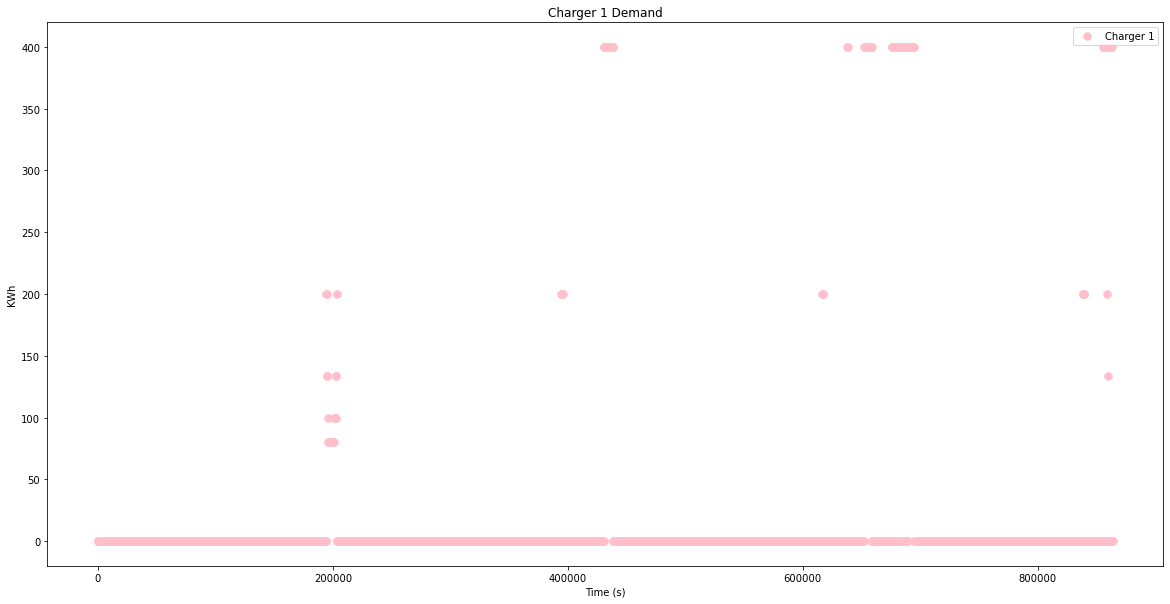

In [12]:
import numpy as np
import pandas as pd
 
df = pd.read_csv('test_charger_rate.csv',sep=',')
plt.figure(figsize=(20, 10)) 
display(plt.plot( 'Time (s)', 'Charger 1', data=df, marker='.',markersize=15, color='pink', linewidth=0))


plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('KWh')
plt.title('Charger 1 Demand')

plt.show()



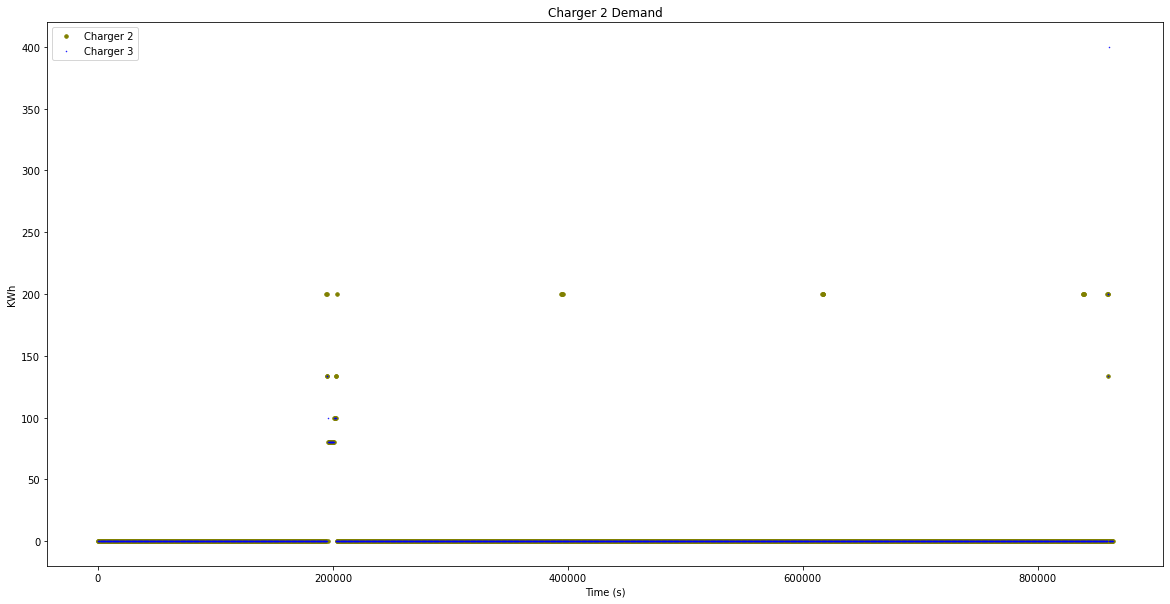

In [13]:
import numpy as np
import pandas as pd
 
df = pd.read_csv('test_charger_rate.csv',sep=',')
plt.figure(figsize=(20, 10)) 
display(plt.plot( 'Time (s)', 'Charger 2', data=df, marker='.', color='olive',markersize=7, linewidth=0))
display(plt.plot( 'Time (s)', 'Charger 3', data=df, marker='.', color='blue', markersize=1, linewidth=0, linestyle='dashed'))

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('KWh')
plt.title('Charger 2 Demand')

plt.show()


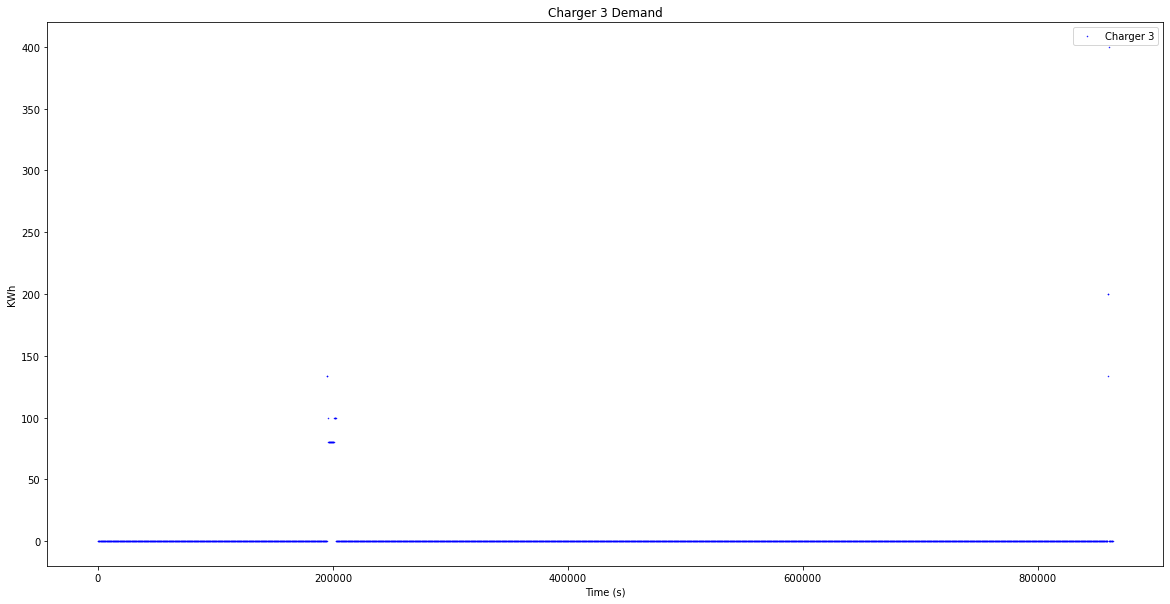

In [14]:
import numpy as np
import pandas as pd
 
df = pd.read_csv('test_charger_rate.csv',sep=',')
plt.figure(figsize=(20, 10)) 
display(plt.plot( 'Time (s)', 'Charger 3', data=df, marker='.', color='blue', markersize=1, linewidth=0, linestyle='dashed'))

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('KWh')
plt.title('Charger 3 Demand')

plt.show()


In [ ]:
import ipynb
from ipynb.fs.full.Visualization import Visualization
visualize = Visualization("test_bus.csv")

     Time (s)  ID     Route           Next stop  \
1           0   1  M14D-SBS        E 14 ST/1 AV   
101       300   1  M14D-SBS        E 14 ST/1 AV   
201       600   1  M14D-SBS        E 14 ST/2 AV   
301       900   1  M14D-SBS        E 14 ST/2 AV   
401      1200   1  M14D-SBS        E 14 ST/3 AV   
501      1500   1  M14D-SBS        E 14 ST/3 AV   
601      1800   1  M14D-SBS        E 14 ST/4 AV   
701      2100   1  M14D-SBS        E 14 ST/4 AV   
801      2400   1  M14D-SBS  E 14 ST/UNION SQ W   
901      2700   1  M14D-SBS  E 14 ST/UNION SQ W   

                                    Direction  Total Distance (Km)  \
1    SELECT BUS CHLSEA PIERS  11 AV via 14 ST                0.000   
101  SELECT BUS CHLSEA PIERS  11 AV via 14 ST                0.000   
201  SELECT BUS CHLSEA PIERS  11 AV via 14 ST                0.212   
301  SELECT BUS CHLSEA PIERS  11 AV via 14 ST                0.212   
401  SELECT BUS CHLSEA PIERS  11 AV via 14 ST                0.441   
501  SELECT BUS CH

Text(0.5, 1.0, 'Test Bus')

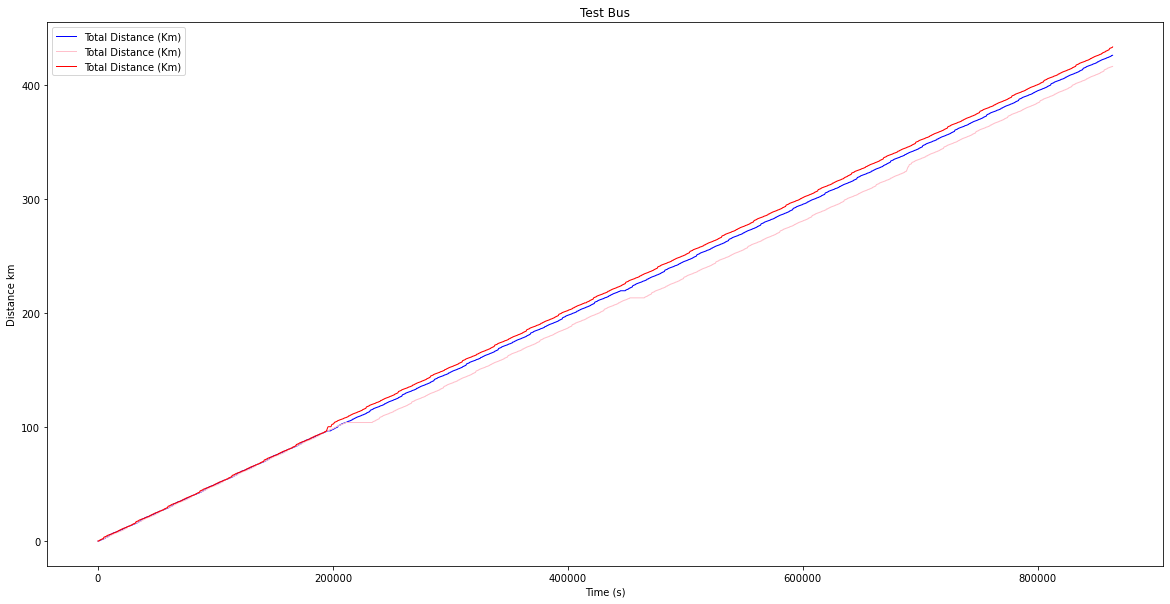

In [15]:
test = pd.read_csv('test_bus.csv',sep=',')
bus_1=test[test["ID"]==1]
bus_2=test[test["ID"]==2]
bus_3=test[test["ID"]==3]

print(bus_1.head(10))

plt.figure(figsize=(20, 10)) 

display(plt.plot('Time (s)', 'Total Distance (Km)', data=bus_1, marker='', color='blue', linewidth=1))
display(plt.plot('Time (s)', 'Total Distance (Km)', data=bus_2, marker='', color='pink', linewidth=1))
display(plt.plot('Time (s)', 'Total Distance (Km)', data=bus_3, marker='', color='red', linewidth=1))

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Distance km')
plt.title('Test Bus')





   Time (s)  Charger 1  Charger 2  Charger 3  Charger 4  Charger 5  Charger 6  \
0         0        0.0        0.0        0.0        0.0        0.0        0.0   
1       300        0.0        0.0        0.0        0.0        0.0        0.0   
2       600        0.0        0.0        0.0        0.0        0.0        0.0   
3       900        0.0        0.0        0.0        0.0        0.0        0.0   
4      1200        0.0        0.0        0.0        0.0        0.0        0.0   

   Charger 7  Charger 8  Charger 9  Charger 10  Charger 11  Charger 12  
0        NaN        NaN        NaN         NaN         NaN         NaN  
1        NaN        NaN        NaN         NaN         NaN         NaN  
2        NaN        NaN        NaN         NaN         NaN         NaN  
3        NaN        NaN        NaN         NaN         NaN         NaN  
4        NaN        NaN        NaN         NaN         NaN         NaN  


Text(0.5, 1.0, 'Test Bus')

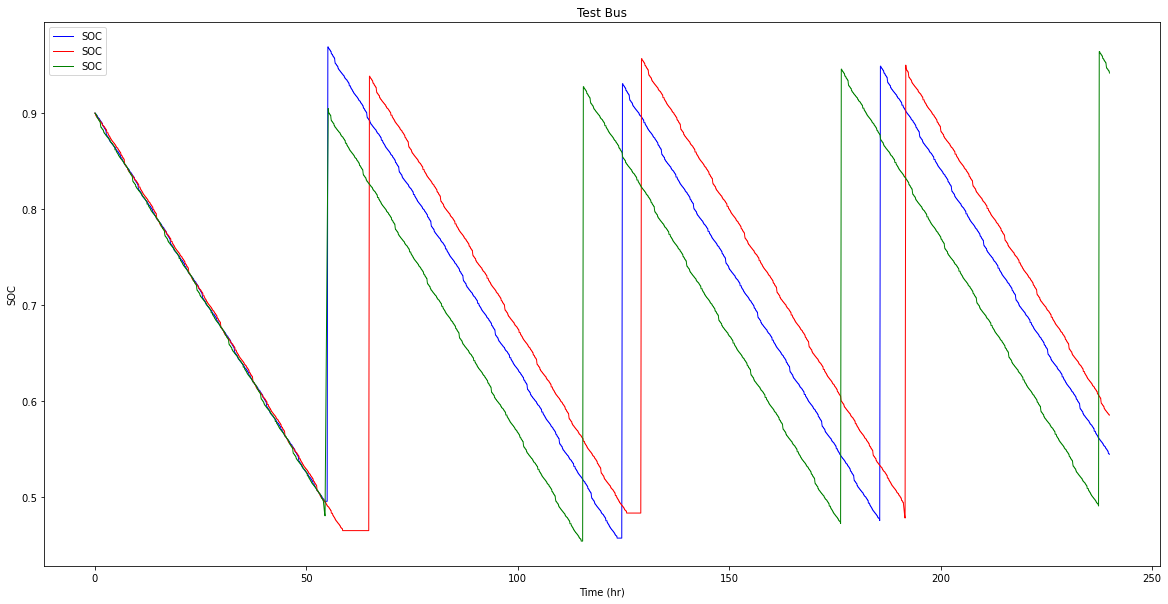

In [16]:


test = pd.read_csv('test_bus.csv',sep=',')

test['Time (hr)']=test['Time (s)']/3600
print(df.head())

bus_1=test[test["ID"]==1]
bus_2=test[test["ID"]==2]
bus_3=test[test["ID"]==3]


#print(bus_1.head(10))

plt.figure(figsize=(20, 10)) 

display(plt.plot('Time (hr)', 'SOC', data=bus_1, marker='', color='blue', linewidth=1))
display(plt.plot('Time (hr)', 'SOC', data=bus_2, marker='', color='red', linewidth=1))
display(plt.plot('Time (hr)', 'SOC', data=bus_3, marker='', color='green', linewidth=1))



plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('SOC')
plt.title('Test Bus')



In [17]:
bus_1.to_csv('out.csv')

In [18]:
soc_bus_1=bus_1["SOC"].to_list()

for i in range(len(soc_bus_1)-1):
    if soc_bus_1[i+1]>soc_bus_1[i]:
        print("here's an error = ",i)
        print(soc_bus_1[i+1])
        print(soc_bus_1[i])

here's an error =  74
0.8533839714285707
0.8533839642857135
here's an error =  165
0.7966720571428555
0.7966720499999984
here's an error =  256
0.7399601428571403
0.7399601357142832
here's an error =  347
0.6832482285714251
0.6832482214285681
here's an error =  438
0.6265363142857099
0.6265363071428528
here's an error =  529
0.5698243999999948
0.5698243928571376
here's an error =  620
0.5131124857142796
0.5131124785714225
here's an error =  659
0.7330878738095172
0.4949926357142792
here's an error =  660
0.9690902619047552
0.7330878738095172
here's an error =  723
0.9284053476190406
0.9284053404761836
here's an error =  814
0.8716934333333254
0.8716934261904683
here's an error =  905
0.8149815190476103
0.8149815119047531
here's an error =  996
0.7582696047618951
0.7582695976190379
here's an error =  1087
0.7015576904761799
0.7015576833333228
here's an error =  1178
0.6448457761904647
0.6448457690476076
here's an error =  1269
0.5881338619047495
0.5881338547618924
here's an error =  136